# Flower Classifier


## Package imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import json
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
from PIL import Image
import os
import random

import torch
from torch import nn, optim
from torch.optim import lr_scheduler#
import torch.nn.functional as F
from torchvision import transforms, datasets, models

## Create and train new model example

In [15]:
#loading model
model = models.densenet201(pretrained=True) 

#freezing parameters
for param in model.parameters():
    param.requires_grad = False
    
# adding custom classifier
model.classifier = Classifier()

#defining optimizer, criterion and lr scheduler
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
criterion = nn.NLLLoss()
schedule = lr_scheduler.StepLR(optimizer, step_size=2, gamma = 0.25)

#training
train_model(model, criterion, optimizer, schedule, epochs=1, print_every=10, save=False) #train model for 1 epoch



Using cpu
Epoch: 1/1


c:\Users\olive\anaconda3\envs\mnist_env\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


KeyboardInterrupt: 

## Load and train example:

In [23]:
model, optimizer = load_checkpoint(model_name='densenet', learn_rate=0.0003) #loading densenet model/optimizer
schedule = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.25) #learn rate scheduler
criterion = nn.NLLLoss() #loss function

train_model(model, criterion, optimizer, schedule, epochs=1, print_every=10, model_name='densenet', save=True) #train model for 1 epoch


test_model(model, criterion, testloader) #test model accuracy on unseen images 



/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Using cuda
Epoch: 1/1
Training loss: 1.858 Validation loss: 1.828 Accuracy: 50.580
Model with 50.58% accuracy has been saved
Training loss: 1.572 Validation loss: 1.469 Accuracy: 60.143
Model with 60.14% accuracy has been saved
Training loss: 1.382 Validation loss: 1.311 Accuracy: 64.545
Training loss: 1.211 Validation loss: 1.058 Accuracy: 71.446
Model with 71.45% accuracy has been saved
Training loss: 1.147 Validation loss: 0.956 Accuracy: 72.848
Epoch 1 took 4.0mins and 11.4s
Test loss: 1.135 Accuracy: 67.769


## Load and check results example:

Flower name: tiger lily
Prediction: peruvian lily


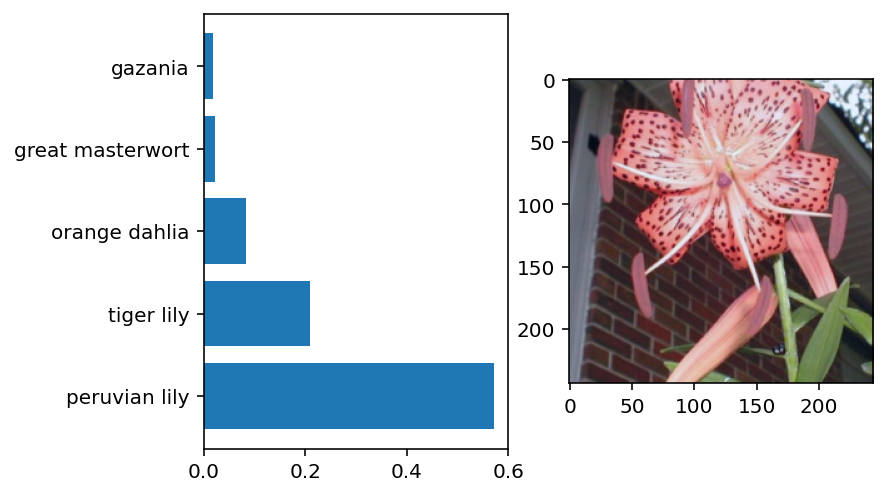

In [20]:
model ,_ = load_checkpoint(model_name='densenet', learn_rate=0.003) #underscore holds the optimizer which isnt needed here
plots(model,topk=5) #plot a random unseen image from test images and its top 5 predictions

## Loading data

In [2]:
# image/label directories #
data_dir = 'flowers'
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'
valid_dir = f'{data_dir}/valid'


In [3]:
# Training data augmentation and Data normalization #

train_transforms = transforms.Compose([transforms.RandomResizedCrop(244),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(245),
                                     transforms.CenterCrop(244),
                                     transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(245),
                                     transforms.CenterCrop(244),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# Data loading
train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transforms)

# Data batching
batch_size = 128

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)


## Label mapping

In [4]:
# Shows what species each integer label corresponds to
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name['11'], cat_to_name['4']

('snapdragon', 'sweet pea')

## Feedforward Classifier
The feedforward network is defined for use as a classifier using the features as input

In [5]:
class Classifier(nn.Module):
#defaulting the numeber of layers/features per layer to fit  densenet201 model
    def __init__(self, in_features = 1920, h1 = 1024, out_features = 102):
        ''' args: 
                  in_features -> features going into first layer
                  h1 -> features going into hidden layer
                  out_features -> number of categories (102 for flowers)
                  
        '''
        super().__init__()
        
        self.inp = nn.Linear(in_features, h1)
        self.h1 = nn.Linear(h1, h1)
        self.out = nn.Linear(h1, out_features)
    
    def forward(self, x):
        '''
            performs forward pass on x
            
        '''
        
        x = F.dropout(F.relu(self.inp(x)), p = 0.5)
        
        x = F.dropout(F.relu(self.h1(x)), p=0.5)
        
        x = F.log_softmax(self.out(x), dim=1)
        
        return x

## Validation function
During training, the validation loss and accuracy are displayed

In [6]:
def validate_model(model, criterion, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    test_loss = 0
    accuracy = 0

    with torch.no_grad():

        for images, labels in dataloader:

            images = images.to(device)
            labels = labels.to(device)

            output = model.forward(images)

            test_loss += float(criterion(output, labels))

            ps = torch.exp(output)
            top_p, top_class = torch.topk(ps, 1, dim=1,)

            correct = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(correct.type(torch.FloatTensor))
            
            
    validation = {'test_loss': test_loss/len(dataloader),
                 'accuracy': 100*accuracy/len(dataloader)}
            
    model.train()
    return validation

## Training function
The parameters of the feedforward classifier are trained, while the parameters of the feature network are left static

In [7]:

def train_model(model, criterion, optimizer, sched,
                epochs=5, print_every = 5, model_name = 'densenet',
                save = True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')
    
    model = model.to(device) # choose cuda/cpu to enhance model training speed
    best_accuracy =0
    model.train()
    
    steps = 0
    running_loss = 0
    
    for e in range(epochs):
        print(f'Epoch: {e+1}/{epochs}')

        start = time.time()
    
        sched.step() # increments the learning rate scheduler every epoch
        
        ## Training ##
        
        for images, labels in  trainloader:
            steps += 1
            
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += float(loss)
        
        
        ## validation ##
        
            if steps % print_every ==0:
                
                validation = validate_model(model, criterion, validloader)
                
                accuracy = validation['accuracy'] 
                test_loss = validation['test_loss']
                
                print(f'Training loss: {running_loss/print_every:.3f}',
                        f'Validation loss: {test_loss:.3f}',
                        f'Accuracy: {accuracy:.3f}')
                
                running_loss = 0
                if save:
                    if (accuracy - best_accuracy) > 5:
                        best_accuracy = accuracy
                        #save a checkpoint if accuracy has improved my more than 5bps
                        print(f'Model with {accuracy:.2f}% accuracy has been saved')
                        save_checkpoint(model_name, model, optimizer)
                    
        end = time.time()
        epoch_time = end-start
        print(f'Epoch {e+1} took {epoch_time // 60}mins and {epoch_time%60:.1f}s')   
        
    


## Testing accuracy
The network's accuracy is measured on the test data

In [8]:
def test_model(model, criterion, dataloader):
    validation = validate_model(model, criterion, dataloader)
    
    accuracy = validation['accuracy'] 
    test_loss = validation['test_loss']

    print(f'Test loss: {test_loss:.3f}',
          f'Accuracy: {accuracy:.3f}')


## Saving the model
The trained model is saved as a checkpoint along with associated hyperparameters and the class_to_idx dictionary


In [9]:
def save_checkpoint(model_name, model, optimizer):
    checkpoint = {}
    
    #checkpoint['epochs'] = epochs
    checkpoint['optimizer_state'] = optimizer.state_dict()
    checkpoint['class_to_idx'] = train_data.class_to_idx
    checkpoint['model_state'] = model.state_dict()
    
    torch.save(checkpoint, f'{model_name}_checkpoint.pth')


## Loading checkpoints
loading and rebuilding the model

In [10]:
def load_checkpoint(model_name = 'densenet', learn_rate = 0.003):
    
    if model_name == 'densenet':
    #loading the model
        model = models.densenet201(pretrained= True) 
        
        for param in model.parameters():
            param.requires_grad = False
            
        path = 'densenet_checkpoint.pth'
        model.classifier = Classifier()
        
        #loading the optimizer
        optimizer = optim.Adam(model.classifier.parameters(),
                                           lr = learn_rate) 
        
    if model_name == 'resnet':
        
        model = models.resnet152(pretrained= True) 
        
        for param in model.parameters():
            param.requires_grad = False
            
        path = 'resnet_checkpoint.pth'

        model.fc = Classifier(in_features=8192, 
                                      h1=500, 
                                      out_features = 102)
        #loading the optimizer
        optimizer = optim.Adam(model.fc.parameters(),
                               lr = learn_rate)

    if torch.cuda.is_available():
        map_location =lambda storage, loc: storage.cuda()
        device = 'cuda'

    else:
        map_location = 'cpu'
        device = 'cpu'



    checkpoint = torch.load(path, map_location=map_location)

    model_state = checkpoint['model_state']
    model.load_state_dict(model_state)

    class_to_idx = checkpoint['class_to_idx']
    model.class_to_idx = class_to_idx
    model.to(device)



    optimizer_state = checkpoint['optimizer_state']
    optimizer.load_state_dict(optimizer_state)

    return model, optimizer

## Checking results with graphs!!

-processing single image to be ran through network

-turn the tensor back into an image that can be displayed

-loading the model and making a prediction

In [11]:
def process_image(image, transform):
    image = transform(image)
    image = image.view(1, image.shape[0], image.shape[1], image.shape[2])
    return image

In [12]:
def tensor2img(image):
    
    image = image.view(image.shape[1], image.shape[2], image.shape[3])
    
    image = image.permute(1,2,0)
    
    image = (image-torch.min(image))/(torch.max(image)-torch.min(image))
        
    image = np.array(image)
    
    
    return image
    

In [13]:
def predict(image,model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    image = image.to(device) #tensor.to() happens out of place with tensors, in place with models
    model.to(device)
    
    with torch.no_grad():
        model.eval()
        ps = torch.exp(model.forward(image))
        model.train()
        
    
    top_p, top_class = ps.topk(topk)
    
    top_p = np.array(top_p[0])
    top_class = np.array(top_class[0]).astype('str')
    
        
        
    return(top_p, top_class)
    

In [14]:
def plots(model,topk=5):
    
    #generating a random path to test different images
    cat = random.choice(os.listdir("flowers/test"))
    im = random.choice(os.listdir(f"flowers/test/{cat}"))
    path = f"flowers/test/{cat}/{im}"
    
    class_to_idx = model.class_to_idx

    with Image.open(path) as image:
        input_img = process_image(image, test_transforms)

        
    #gettting the topk
    top_p, top_class = predict(input_img, model, topk = topk)

    
    #converting index to class
    #initialising categories
    categories = [None for i in range(topk)]
    #swapping keys and values in class_to_idx
    idx_to_class = {str(v): k for k, v in class_to_idx.items()}
    
    for i in range(topk): # there are topk values in categories list
        categories[i] = cat_to_name[idx_to_class[top_class[i]]]
    
    
    print(f'Flower name: {cat_to_name[str(cat)]}')
    print(f'Prediction: {categories[0]}')
    plt.subplot(1,2,1)
    plt.barh(categories, top_p)
    plt.subplot(1,2,2)
    plt.imshow(tensor2img(input_img))